In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MiniBatchKMeans

# Tarea 2

Escoger un dataset tabular, y usar las técnicas aprendidas de clustering (k-means y DB-Scan), investigar y hacer una implementación desde cero de BFR, y comparar el resultado de los tres. ¿Qué métrica usaría?

## Datos que se usan en el notebook

El dataset Mallows es un dataset que contiene información sobre clientes de un centro comercial. Cada fila representa un cliente y las columnas contienen características como el ingreso, la edad, el género, etc. Este dataset es útil para realizar análisis de segmentación de clientes y clustering.

In [ ]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


El tamaño del dataset

In [3]:
df.shape

(200, 5)

## Limpieza de datos

Miremos si hay valores nulos

In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

El dataset no tiene valores nulos, vamos a ver si los tipos de datos son adecuados

In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df["Gender"].unique()

array(['Male', 'Female'], dtype=object)

Vemos que los tipos de datos son adecuados, pero la columna `Gender` tiene 2 valores unicos, `Male` y `Female`. Vamos a aplicar un mapping para convertirlos a 0 y 1, respectivamente

In [7]:
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


Ahora ya todos los valores son numericos, pero no nos interesa mucho la columna customerID, pero antes de eliminarla, verifiquemos que no hayan duplicados

In [8]:
df["CustomerID"].duplicated().sum()

np.int64(0)

Como no hay duplicados, podemos eliminar la columna customerID

In [9]:
df = df.drop(columns=["CustomerID"])

Ahora vamos a estandarizar los datos, para que tengan media 0 y desviacion estandar 1. Esto es importante para el algoritmo KMeans, ya que este algoritmo se basa en distancias euclidianas.

In [10]:
for col in df.columns:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,-1.125328,-1.421003,-1.734646,-0.433713
1,-1.125328,-1.277829,-1.734646,1.192711
2,0.884186,-1.349416,-1.696572,-1.711618
3,0.884186,-1.134655,-1.696572,1.037814
4,0.884186,-0.561958,-1.658498,-0.394989


Ahora que tenemos el dataset listo para aplicar algoritmos de clustering.

## Clustering

### Algoritmos

#### BFR

El algoritmo BFR hace las siguientes suposiciones:
- Los clusters estan normalmente distribuidos en cada dimension
- Los ejes estan fijos, es decir, elipses en un angulo no estan bien

![image](BFR.png)

[Referencia](https://www.youtube.com/watch?v=JrOJspZ1CUw)

#### BFR

In [11]:

class CFEntry:
    """
    Representa una entrada de Cluster Feature (CF) para resumir un cluster.
    """
    def __init__(self, N=0, LS=None, SS=None):
        self.N = N # Número de puntos en el cluster
        self.LS = LS # Suma lineal de los puntos (vector)
        self.SS = SS # Suma de los cuadrados de los puntos (vector)

    def add_point(self, point):
        """Añade un punto a la CF."""
        if self.N == 0:
            self.LS = np.copy(point)
            self.SS = np.copy(point ** 2)
        else:
            self.LS += point
            self.SS += point ** 2
        self.N += 1

    def merge_cf(self, other_cf):
        """Fusiona otra CF con esta CF."""
        if self.N == 0:
            self.N = other_cf.N
            self.LS = np.copy(other_cf.LS)
            self.SS = np.copy(other_cf.SS)
        else:
            self.N += other_cf.N
            self.LS += other_cf.LS
            self.SS += other_cf.SS

    def get_centroid(self):
        """Calcula el centroide del cluster."""
        if self.N == 0:
            return None
        return self.LS / self.N

    def get_radius(self):
        """Calcula el radio/desviación estándar (simplificado)."""
        if self.N <= 1:
            return 0.0
        # sqrt( (sum(x^2)/N) - (sum(x)/N)^2 ) -> Desviación estándar
        variance = (self.SS / self.N) - (self.LS / self.N)**2
        return np.sqrt(np.maximum(0, np.sum(variance)))

class BFRClustering:
    """
    Implementación conceptual del algoritmo de clustering BFR envuelto en una clase.
    Diseñado para procesar datos en chunks, adecuado para grandes datasets o streams.
    """
    def __init__(self, initial_n_clusters, distance_threshold,
                 cs_threshold_factor=2.0, rs_max_size=1000, chunk_size=1000, random_state=None):
        """
        Inicializa el algoritmo BFR.

        Args:
            initial_n_clusters (int): Número de clusters para la fase de inicialización.
            distance_threshold (float): Umbral de distancia para absorber puntos en el DS.
            cs_threshold_factor (float): Factor para determinar si una CF del CS es candidata a moverse al DS.
            rs_max_size (int): Tamaño máximo del Retained Set antes de re-clustering.
            chunk_size (int): Tamaño de los pedazos de datos a procesar en cada iteración.
            random_state (int, optional): Semilla para la aleatoriedad. Defaults to None.
        """
        self.initial_n_clusters = initial_n_clusters
        self.distance_threshold = distance_threshold
        self.cs_threshold_factor = cs_threshold_factor
        self.rs_max_size = rs_max_size
        self.chunk_size = chunk_size
        self.random_state = random_state

        self.discard_set = []  # Lista de CFEntry para clusters bien establecidos
        self.compression_set = [] # Lista de CFEntry para clusters temporales
        self.retained_set = [] # Lista de puntos individuales (outliers o no agrupados)
        self.labels_ = None # Atributo para almacenar las etiquetas de cluster finales
        self.n_features = None # Número de características de los datos

    def _process_chunk(self, chunk):
        """
        Procesa un pedazo de datos, intentando asignar puntos a DS, CS o RS.
        """
        if self.n_features is None and chunk.shape[0] > 0:
            self.n_features = chunk.shape[1]

        for point in chunk:
            assigned = False

            # Intento de asignación al Discard Set (DS)
            best_ds_cf = None
            min_ds_dist = float('inf')
            for cf in self.discard_set:
                centroid = cf.get_centroid()
                if centroid is not None:
                    dist = np.linalg.norm(point - centroid)
                    if dist < min_ds_dist:
                        min_ds_dist = dist
                        best_ds_cf = cf

            if best_ds_cf and best_ds_cf.get_radius() > 0 and min_ds_dist <= self.distance_threshold * best_ds_cf.get_radius():
                best_ds_cf.add_point(point)
                assigned = True
            elif best_ds_cf and best_ds_cf.get_radius() == 0 and min_ds_dist <= self.distance_threshold: # Caso de radio 0
                 best_ds_cf.add_point(point)
                 assigned = True
            else:
                # Intento de asignación al Compression Set (CS)
                best_cs_cf = None
                min_cs_dist = float('inf')
                for cf in self.compression_set:
                    centroid = cf.get_centroid()
                    if centroid is not None:
                        dist = np.linalg.norm(point - centroid)
                        if dist < min_cs_dist:
                            min_cs_dist = dist
                            best_cs_cf = cf

                if best_cs_cf and best_cs_cf.get_radius() > 0 and min_cs_dist <= self.distance_threshold * best_cs_cf.get_radius():
                    best_cs_cf.add_point(point)
                    assigned = True
                elif best_cs_cf and best_cs_cf.get_radius() == 0 and min_cs_dist <= self.distance_threshold: # Caso de radio 0
                     best_cs_cf.add_point(point)
                     assigned = True
                else:
                    # Añadir al Retained Set (RS)
                    self.retained_set.append(point)
                    assigned = True

            # Verificar y procesar el RS si excede el tamaño máximo
            if len(self.retained_set) > self.rs_max_size:
                self._recluster_cs_and_rs()

    def _recluster_cs_and_rs(self):
        """
        Realiza la fase intermedia de re-clustering y fusión para CS y RS.
        """
        # Paso 1: Intentar fusionar CFs de CS entre sí y luego con DS
        new_compression_set = []
        for cf_cs in self.compression_set:
            merged_to_ds = False
            for cf_ds in self.discard_set:
                if cf_ds.get_centroid() is not None and cf_cs.get_centroid() is not None:
                    # Umbral de fusión basado en la proximidad y el radio del cluster DS
                    if np.linalg.norm(cf_ds.get_centroid() - cf_cs.get_centroid()) < self.distance_threshold * cf_ds.get_radius() * self.cs_threshold_factor:
                        cf_ds.merge_cf(cf_cs)
                        merged_to_ds = True
                        break
            if not merged_to_ds:
                new_compression_set.append(cf_cs)
        self.compression_set = new_compression_set

        # Paso 2: Procesar el Retained Set (RS)
        if len(self.retained_set) > 0 and self.n_features is not None:
            rs_points_array = np.array(self.retained_set)
            if rs_points_array.shape[0] > 0 and rs_points_array.ndim > 1:
                # Determinar un número de clusters razonable para RS
                n_clusters_rs = max(1, min(self.initial_n_clusters, rs_points_array.shape[0] // 10))
                if n_clusters_rs > 0:
                    rs_kmeans = MiniBatchKMeans(n_clusters=n_clusters_rs, random_state=self.random_state, n_init='auto')
                    rs_labels = rs_kmeans.fit_predict(rs_points_array)

                    for i in range(n_clusters_rs):
                        rs_cluster_points = rs_points_array[rs_labels == i]
                        if rs_cluster_points.shape[0] > 0:
                            new_rs_cf = CFEntry(N=0, LS=np.zeros(self.n_features), SS=np.zeros(self.n_features))
                            for p in rs_cluster_points:
                                new_rs_cf.add_point(p)

                            merged_to_ds_or_cs = False
                            # Intentar fusionar con DS
                            for cf_ds in self.discard_set:
                                if cf_ds.get_centroid() is not None and new_rs_cf.get_centroid() is not None:
                                    if np.linalg.norm(cf_ds.get_centroid() - new_rs_cf.get_centroid()) < self.distance_threshold * cf_ds.get_radius() * self.cs_threshold_factor:
                                        cf_ds.merge_cf(new_rs_cf)
                                        merged_to_ds_or_cs = True
                                        break
                            if not merged_to_ds_or_cs:
                                # Intentar fusionar con CS
                                for cf_cs in self.compression_set:
                                    if cf_cs.get_centroid() is not None and new_rs_cf.get_centroid() is not None:
                                        if np.linalg.norm(cf_cs.get_centroid() - new_rs_cf.get_centroid()) < self.distance_threshold * cf_cs.get_radius() * self.cs_threshold_factor:
                                            cf_cs.merge_cf(new_rs_cf)
                                            merged_to_ds_or_cs = True
                                            break
                            if not merged_to_ds_or_cs:
                                self.compression_set.append(new_rs_cf)
            self.retained_set = [] # Vaciar RS después del procesamiento

    def fit(self, X):
        """
        Ajusta el modelo BFR a los datos de entrada.
        Procesa los datos en chunks si X es un array grande.

        Args:
            X (np.array): Los datos de entrada, de forma (n_samples, n_features).
                          Se asume que es el dataset completo para esta versión,
                          pero el procesamiento interno es por chunks.
        """
        n_samples = X.shape[0]
        self.n_features = X.shape[1]

        # Fase de inicialización
        # Tomar el primer chunk para inicializar el DS
        initial_chunk = X[:self.chunk_size]
        if initial_chunk.shape[0] < self.initial_n_clusters:
            effective_initial_clusters = max(1, initial_chunk.shape[0])
        else:
            effective_initial_clusters = self.initial_n_clusters

        if initial_chunk.shape[0] > 0:
            initial_kmeans = MiniBatchKMeans(n_clusters=effective_initial_clusters, random_state=self.random_state, n_init='auto')
            initial_labels = initial_kmeans.fit_predict(initial_chunk)

            for i in range(effective_initial_clusters):
                cluster_points = initial_chunk[initial_labels == i]
                if cluster_points.shape[0] > 0:
                    new_cf = CFEntry(N=0, LS=np.zeros(self.n_features), SS=np.zeros(self.n_features))
                    for point in cluster_points:
                        new_cf.add_point(point)
                    self.discard_set.append(new_cf)
        else:
            print("Advertencia: El primer chunk está vacío. No se pueden inicializar clusters.")
            self.labels_ = np.array([])
            return self

        # Procesar chunks subsiguientes
        for i in range(self.chunk_size, n_samples, self.chunk_size):
            chunk = X[i : i + self.chunk_size]
            self._process_chunk(chunk)

        # Fase Final de Consolidación
        # Consolidar los clusters del Compression Set (CS) con el Discard Set (DS)
        for cf_cs in self.compression_set:
            merged = False
            best_merge_ds_cf = None
            min_merge_dist = float('inf')

            for cf_ds in self.discard_set:
                if cf_ds.get_centroid() is not None and cf_cs.get_centroid() is not None:
                    dist = np.linalg.norm(cf_ds.get_centroid() - cf_cs.get_centroid())
                    # Un umbral de fusión más flexible para el final
                    if dist < min_merge_dist and dist < self.distance_threshold * cf_ds.get_radius() * self.cs_threshold_factor * 2:
                        min_merge_dist = dist
                        best_merge_ds_cf = cf_ds

            if best_merge_ds_cf:
                best_merge_ds_cf.merge_cf(cf_cs)
                merged = True
            if not merged:
                self.discard_set.append(cf_cs)

        # Opcional: Procesar los puntos restantes en el Retained Set
        if len(self.retained_set) > 0 and self.n_features is not None:
            rs_points_array = np.array(self.retained_set)
            if rs_points_array.shape[0] > 0 and rs_points_array.ndim > 1:
                final_rs_clusters_count = max(1, min(len(self.discard_set), rs_points_array.shape[0] // 50))
                if final_rs_clusters_count > 0:
                    rs_kmeans_final = MiniBatchKMeans(n_clusters=final_rs_clusters_count, random_state=self.random_state, n_init='auto')
                    rs_labels_final = rs_kmeans_final.fit_predict(rs_points_array)

                    for i in range(final_rs_clusters_count):
                        rs_cluster_points = rs_points_array[rs_labels_final == i]
                        if rs_cluster_points.shape[0] > 0:
                            new_rs_cf_final = CFEntry(N=0, LS=np.zeros(self.n_features), SS=np.zeros(self.n_features))
                            for p in rs_cluster_points:
                                new_rs_cf_final.add_point(p)
                            # Intentar fusionar con DS, si no, añadir como nuevo cluster
                            merged_to_ds = False
                            for cf_ds in self.discard_set:
                                if cf_ds.get_centroid() is not None and new_rs_cf_final.get_centroid() is not None:
                                    if np.linalg.norm(cf_ds.get_centroid() - new_rs_cf_final.get_centroid()) < self.distance_threshold * cf_ds.get_radius() * self.cs_threshold_factor * 3:
                                        cf_ds.merge_cf(new_rs_cf_final)
                                        merged_to_ds = True
                                        break
                            if not merged_to_ds:
                                self.discard_set.append(new_rs_cf_final)

        # Asignar etiquetas finales a los puntos originales
        self.labels_ = np.full(n_samples, -1, dtype=int) # -1 para puntos no asignados/outliers
        for i in range(n_samples):
            point = X[i]
            min_dist = float('inf')
            assigned_cluster_idx = -1
            for cluster_idx, cf in enumerate(self.discard_set):
                centroid = cf.get_centroid()
                if centroid is not None:
                    dist = np.linalg.norm(point - centroid)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_cluster_idx = cluster_idx
            self.labels_[i] = assigned_cluster_idx
        
        return self

    def get_cluster_centroids(self):
        """
        Devuelve los centroides de los clusters finales.
        """
        return np.array([cf.get_centroid() for cf in self.discard_set if cf.get_centroid() is not None])

### Aplicacion de algoritmos

#### Evaluar K-Means

In [12]:
best_n_clusters = 0
best_score = -1
X = df.values

# Cross-validation para encontrar el mejor número de clusters
for n in range(2, 11):
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    scores = []

    for train_index, val_index in kf.split(df):
        X_train, X_val = X[train_index], X[val_index]
        model = KMeans(n_clusters=n, random_state=1234)
        model.fit(X_train)
        labels = model.predict(X_val)

        score = silhouette_score(X_val, labels)
        scores.append(score)

    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_n_clusters = n

print(f"Mejor número de clusters: {best_n_clusters} con una puntuación de silueta de {best_score:.2f}")

# Aplicar KMeans con el mejor número de clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=1234)
kmeans.fit(X)
labels = kmeans.labels_
df["KMeans_Labels"] = labels

Mejor número de clusters: 9 con una puntuación de silueta de 0.35


#### Evaluar DB-Scan

In [13]:
# Evaluar dbscan
dbscan = DBSCAN(eps = 2) # Valores mas pequeños deja puntos sin cluster
dbscan.fit(df.values)
dbscan_labels = dbscan.labels_
df["DBSCAN_Labels"] = dbscan_labels

#### Evaluar BFR

In [14]:
bfr = BFRClustering(initial_n_clusters=9, distance_threshold=2.0, cs_threshold_factor=2.0, rs_max_size=50, chunk_size=50, random_state=1234)
bfr.fit(X)
df["BFR_Labels"] = bfr.labels_

### Visualizacion de resultados

Como el dataset tiene 5 dimensiones, vamos a reducirlo a 2 dimensiones usando PCA para poder visualizar los resultados de los algoritmos de clustering.

In [15]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)
df_pca = pd.DataFrame(data=pca_result, columns=["PCA1", "PCA2"]) # DataFrame con las dos componentes principales

Agregar las etiquetas de los clusters al DataFrame reducido

In [16]:
df_pca["KMeans_Labels"] = df["KMeans_Labels"]
df_pca["DBSCAN_Labels"] = df["DBSCAN_Labels"]
df_pca["BFR_Labels"] = df["BFR_Labels"]

#### K-Means

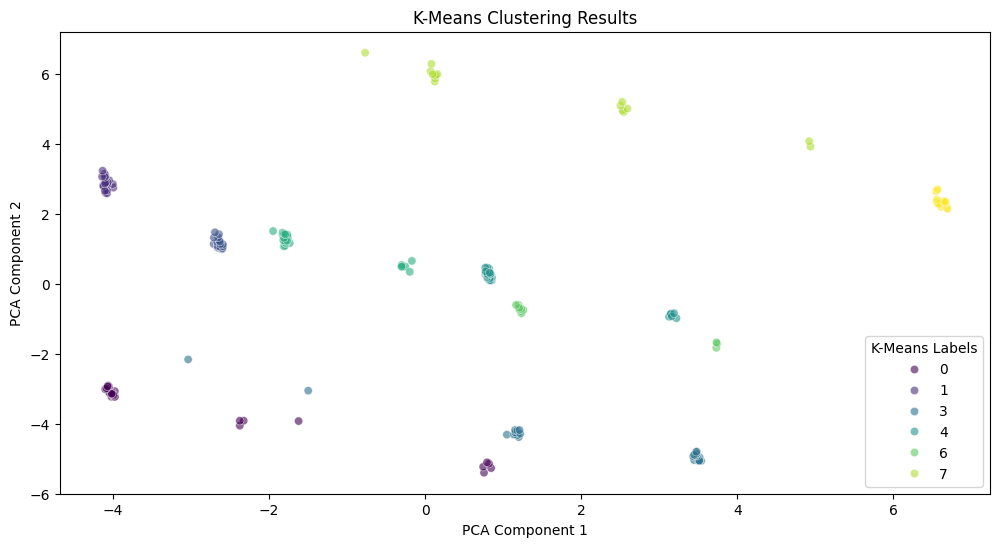

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="KMeans_Labels", palette="viridis", alpha=0.6)
plt.title("K-Means Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="K-Means Labels")
plt.show()

#### DB-Scan

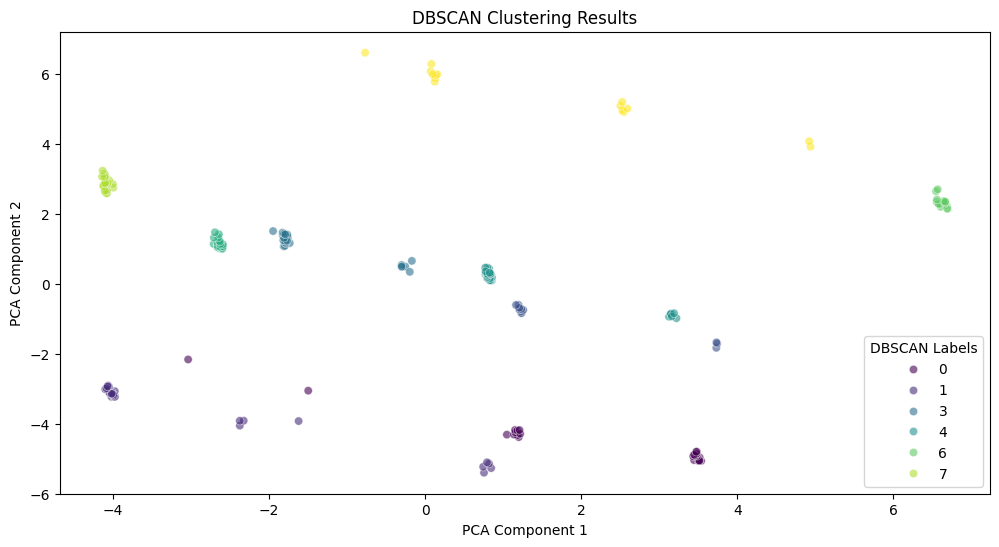

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="DBSCAN_Labels", palette="viridis", alpha=0.6)
plt.title("DBSCAN Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="DBSCAN Labels")
plt.show()

#### BFR

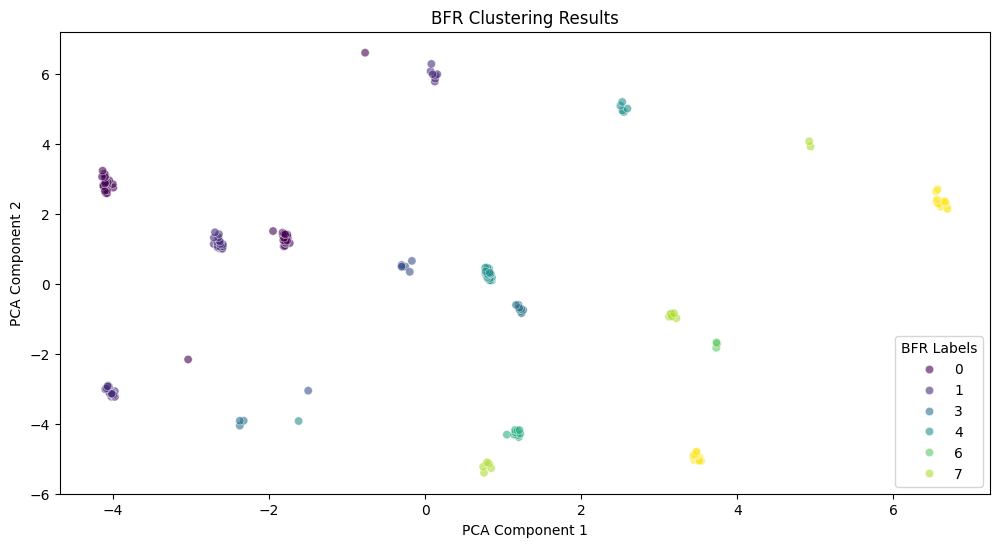

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="BFR_Labels", palette="viridis", alpha=0.6)
plt.title("BFR Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="BFR Labels")
plt.show()

### Comparacion de resultados

#### Metricas

Como no tenemos una variable supervisada, la literatura sugiere las siguientes metricas para evaluar los resultados de los algoritmos de clustering:

- **Silhouette Score**: Mide la calidad de la agrupación, donde un valor cercano a 1 indica que los puntos están bien agrupados.
- **Davies-Bouldin Index**: Mide la separación entre los clusters, donde un valor más bajo indica una mejor separación.
- **Calinski-Harabasz Index**: Mide la compacidad y separación de los clusters, donde un valor más alto indica una mejor calidad de clustering.

Igualmente el tema de las metricas en clustering es un tema complejo al no tener una variable supervisada, por lo que es importante tener en cuenta el contexto del problema y los objetivos del clustering al elegir las metricas.

In [20]:
# Metricas para K-Means
kmeans_silhouette = silhouette_score(df.values, df["KMeans_Labels"])
kmeans_davies_bouldin = davies_bouldin_score(df.values, df["KMeans_Labels"])
kmeans_calinski_harabasz = calinski_harabasz_score(df.values, df["KMeans_Labels"])
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"K-Means Davies-Bouldin Score: {kmeans_davies_bouldin}")
print(f"K-Means Calinski-Harabasz Score: {kmeans_calinski_harabasz}\n",)

# Metricas para DBSCAN
dbscan_silhouette = silhouette_score(df.values, df["DBSCAN_Labels"])
dbscan_davies_bouldin = davies_bouldin_score(df.values, df["DBSCAN_Labels"])
dbscan_calinski_harabasz = calinski_harabasz_score(df.values, df["DBSCAN_Labels"])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
print(f"DBSCAN Davies-Bouldin Score: {dbscan_davies_bouldin}")
print(f"DBSCAN Calinski-Harabasz Score: {dbscan_calinski_harabasz}\n")

# Metricas para BFR
bfr_silhouette = silhouette_score(df.values, df["BFR_Labels"])
bfr_davies_bouldin = davies_bouldin_score(df.values, df["BFR_Labels"])
bfr_calinski_harabasz = calinski_harabasz_score(df.values, df["BFR_Labels"])
print(f"BFR Silhouette Score: {bfr_silhouette}")
print(f"BFR Davies-Bouldin Score: {bfr_davies_bouldin}")
print(f"BFR Calinski-Harabasz Score: {bfr_calinski_harabasz}")


K-Means Silhouette Score: 0.6088872924639253
K-Means Davies-Bouldin Score: 0.6004248425368445
K-Means Calinski-Harabasz Score: 173.34644962017512

DBSCAN Silhouette Score: 0.6088872924639253
DBSCAN Davies-Bouldin Score: 0.6004248425368446
DBSCAN Calinski-Harabasz Score: 173.34644962017512

BFR Silhouette Score: 0.2317947122423255
BFR Davies-Bouldin Score: 1.4140618766721178
BFR Calinski-Harabasz Score: 32.77067314856087


#### Conclusiones

Vemos que el algoritmo K-Means armo los mismos clusters que el algoritmo DB-Scan. Lo cual es curioso, ya que el algoritmo K-Means es un algoritmo de clustering basado en centroides.

Esta coincidencia sugiere que los clusters presentes en este conjunto de datos son compactos, bien separados y densamente poblados, lo que permite que ambos enfoques lleguen a resultados similares a pesar de sus diferencias metodológicas.

Ademas de las graficas, parece ver que los grupos en cualquier caso estan bien agrupados, por lo que en mi criterio la metrica esto hace que la metrica mas relevante es la de Davies-Bouldin, que me indica que tan separados estan los grupos, ya no me interesa tanto la metrica de Silhouette Score, ya que los grupos estan bien agrupados.

El algoritmo de BFR rinde peor que los otros dos en todas las metricas, lo cual es importante recordar que en este caso no se tomo ventaja de que los datos tenian gran dimensionalidad y que tenian un gran volumen.

Por lo tanto la simplicidad de los datos y su baja dimensionalidad hacen convenientes el uso de K-Means y DB-Scan, que son algoritmos más simples y rápidos en este caso.

Por lo que me quedaria con el clustering que hizo K-Means.

### Insights

Vamos a volver a cargar el dataset original y agregar la columna de clusters del algoritmo K-Means, para ver insights sobre los clusters.

In [21]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),KMeans_Labels,DBSCAN_Labels,BFR_Labels
0,-1.125328,-1.421003,-1.734646,-0.433713,3,0,5
1,-1.125328,-1.277829,-1.734646,1.192711,3,0,5
2,0.884186,-1.349416,-1.696572,-1.711618,0,1,7
3,0.884186,-1.134655,-1.696572,1.037814,6,2,3
4,0.884186,-0.561958,-1.658498,-0.394989,0,1,3


In [23]:
original = pd.read_csv("Mall_Customers.csv")
original = original.drop(columns=["CustomerID"])
original["cluster"] = df["KMeans_Labels"]
original.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,3
1,Male,21,15,81,3
2,Female,20,16,6,0
3,Female,23,16,77,6
4,Female,31,17,40,0


In [24]:
original.groupby('cluster').describe().T


cluster                               0           1           2          3  \
Age                    count  30.000000   19.000000   22.000000  25.000000   
                       mean   28.533333   38.473684   32.545455  25.720000   
                       std     6.678495   12.001706    3.432718   7.115242   
                       min    18.000000   19.000000   27.000000  18.000000   
                       25%    23.000000   32.500000   30.000000  19.000000   
                       50%    28.500000   40.000000   32.000000  24.000000   
                       75%    33.500000   46.500000   35.000000  31.000000   
                       max    40.000000   59.000000   40.000000  40.000000   
Annual Income (k$)     count  30.000000   19.000000   22.000000  25.000000   
                       mean   50.100000   85.894737   85.272727  40.400000   
                       std    17.227384   16.110365   14.286796  17.358955   
                       min    16.000000   71.000000   69.000000  15.000000   
                       25%    40.000000   77.000000   76.250000  24.000000   
                       50%    55.500000   81.000000   78.500000  42.000000   
                       75%    62.750000   87.500000   94.750000  54.000000   
                       max    76.000000  137.000000  120.000000  67.000000   
Spending Score (1-100) count  30.000000   19.000000   22.000000  25.000000   
                       mean   42.133333   14.210526   80.590909  59.000000   
                       std    13.169278    9.801241    9.158182  18.227726   
                       min     6.000000    1.000000   58.000000  13.000000   
                       25%    40.000000    8.500000   74.250000  49.000000   
                       50%    42.000000   13.000000   81.000000  56.000000   
                       75%    50.750000   17.500000   87.750000  73.000000   
                       max    61.000000   36.000000   95.000000  92.000000   

cluster                               4          5          6           7  \
Age                    count  32.000000  26.000000  13.000000   15.000000   
                       mean   52.968750  58.846154  25.461538   44.600000   
                       std     7.718785   8.048316   5.221995    7.660660   
                       min    42.000000  47.000000  20.000000   34.000000   
                       25%    48.500000  52.250000  22.000000   39.000000   
                       50%    50.000000  59.000000  23.000000   44.000000   
                       75%    58.500000  66.750000  30.000000   49.500000   
                       max    68.000000  70.000000  35.000000   57.000000   
Annual Income (k$)     count  32.000000  26.000000  13.000000   15.000000   
                       mean   48.062500  48.692308  25.692308   92.333333   
                       std    12.878934  14.529334   8.239990   16.438920   
                       min    20.000000  19.000000  16.000000   73.000000   
                       25%    39.750000  43.000000  19.000000   78.000000   
                       50%    48.500000  51.500000  23.000000   88.000000   
                       75%    58.250000  61.750000  33.000000  102.000000   
                       max    67.000000  71.000000  39.000000  126.000000   
Spending Score (1-100) count  32.000000  26.000000  13.000000   15.000000   
                       mean   42.593750  39.846154  80.538462   21.600000   
                       std    14.927479  17.721608  10.697472    9.701252   
                       min     5.000000   3.000000  65.000000    5.000000   
                       25%    40.250000  37.250000  73.000000   16.000000   
                       50%    47.500000  46.000000  77.000000   22.000000   
                       75%    52.250000  51.000000  87.000000   27.500000   
                       max    59.000000  60.000000  99.000000   39.000000   

cluster                                8  
Age                    count   18.000000  
                       mean    33.277

**Insights sobre los clusters:**

- **Cluster 2, 6, 8**: Usuarios con más Spending Score, potencialmente interesados en promociones. Corresponde a gente en una adultez temprana.
- **Cluster 1**: Usuarios con menos Spending Score, probablemente no interesados en promociones. Corresponde a gente en una adultez mediana.
- **Cluster 0, 4, 5**: Clientes con Spending Score medio, potencialmente interesados en promociones. Gran rango de edades.
- **Cluster 3**: Clientes jóvenes y un Spending Score medio.
- **Cluster 7**: Gente mayor con dinero, pero con poco activo en su gasto.